# Lab | Customer Analysis Round 5

For this lab, we still keep using the `marketing_customer_analysis.csv` file that you can find in the `files_for_lab` folder.


### 1. Get the data

We are using the `marketing_customer_analysis.csv` file.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv(r'C:\Users\claud\lab-customer-analysis-round-5\files_for_lab\csv_files\marketing_customer_analysis.csv')


### 2. Dealing with the data

Already done in the round 2.



In [3]:
print('Data frame shape (rows, columns): ', data.shape)

Data frame shape (rows, columns):  (9134, 24)


In [4]:
# Standardizing headers by removing spaces and capital letters
data.columns = [x.strip(' ').lower() for x in data.columns]
data

,customer,state,customer lifetime value,response,coverage,education,effective to date,employmentstatus,gender,income,...,months since policy inception,number of open complaints,number of policies,policy type,policy,renew offer type,sales channel,total claim amount,vehicle class,vehicle size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,...,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,...,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,...,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,...,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large


In [5]:
# Columns types
data.dtypes

customer                          object
state                             object
customer lifetime value          float64
response                          object
coverage                          object
education                         object
effective to date                 object
employmentstatus                  object
gender                            object
income                             int64
location code                     object
marital status                    object
monthly premium auto               int64
months since last claim            int64
months since policy inception      int64
number of open complaints          int64
number of policies                 int64
policy type                       object
policy                            object
renew offer type                  object
sales channel                     object
total claim amount               float64
vehicle class                     object
vehicle size                      object
dtype: object

In [6]:
# Checking NaN values
data.isnull().sum()

customer                         0
state                            0
customer lifetime value          0
response                         0
coverage                         0
education                        0
effective to date                0
employmentstatus                 0
gender                           0
income                           0
location code                    0
marital status                   0
monthly premium auto             0
months since last claim          0
months since policy inception    0
number of open complaints        0
number of policies               0
policy type                      0
policy                           0
renew offer type                 0
sales channel                    0
total claim amount               0
vehicle class                    0
vehicle size                     0
dtype: int64

### 3. Explore the data

Some datasets have values that are missing, invalid, or otherwise difficult for an algorithm to process. If data is missing, the algorithm can’t use it. If data is invalid, the algorithm produces less accurate or even misleading outcomes. Some datasets are relatively clean but need to be shaped (e.g., aggregated or pivoted) and many datasets are just lacking useful business context (e.g., poorly defined ID values), hence the need for feature enrichment. Good data preparation produces clean and well-curated data which leads to more practical, accurate model outcomes.


   **3.1.- Determine the problems**
    
   **3.2.- Data cleaning** Cleaning the data is very important as the model learning from that data only, so if we feed inconsistent, appropriate data to model it will return garbage only, so it is required to make sure that the data does not contains any unseen problem.
     
       - Feature and Target Variables
       - Data Types
       - Missing data, check null values
       - Outliers
       - Duplicate data
        
   **3.3.- Feature selection** (Which variables are important to answer our questions?)
    
   **3.4.- Data transformation**

In [7]:
# 3.1.- Determine the problems
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer                       9134 non-null   object 
 1   state                          9134 non-null   object 
 2   customer lifetime value        9134 non-null   float64
 3   response                       9134 non-null   object 
 4   coverage                       9134 non-null   object 
 5   education                      9134 non-null   object 
 6   effective to date              9134 non-null   object 
 7   employmentstatus               9134 non-null   object 
 8   gender                         9134 non-null   object 
 9   income                         9134 non-null   int64  
 10  location code                  9134 non-null   object 
 11  marital status                 9134 non-null   object 
 12  monthly premium auto           9134 non-null   i

In [8]:
# summary of the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer lifetime value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
monthly premium auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
months since last claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
months since policy inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
number of open complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
number of policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
total claim amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678


In [9]:
# checking duplicates
duplicateRows = data[data.duplicated()]
print(duplicateRows)

Empty DataFrame
Columns: [customer, state, customer lifetime value, response, coverage, education, effective to date, employmentstatus, gender, income, location code, marital status, monthly premium auto, months since last claim, months since policy inception, number of open complaints, number of policies, policy type, policy, renew offer type, sales channel, total claim amount, vehicle class, vehicle size]
Index: []

[0 rows x 24 columns]


In [10]:
# numeric data into dataframe called numerical
numerical = data.select_dtypes(include=[np.number])
numerical

,customer lifetime value,income,monthly premium auto,months since last claim,months since policy inception,number of open complaints,number of policies,total claim amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247
3,7645.861827,0,106,18,65,0,7,529.881344
4,2813.692575,43836,73,12,44,0,1,138.130879
...,...,...,...,...,...,...,...,...
9129,23405.987980,71941,73,18,89,0,2,198.234764
9130,3096.511217,21604,79,14,28,0,1,379.200000
9131,8163.890428,0,85,9,37,3,2,790.784983
9132,7524.442436,21941,96,34,3,0,3,691.200000


In [11]:
# correlations matrix
correlations_matrix = numerical.corr()
correlations_matrix

,customer lifetime value,income,monthly premium auto,months since last claim,months since policy inception,number of open complaints,number of policies,total claim amount
customer lifetime value,1.000000,0.024366,0.396262,0.011517,0.009418,-0.036343,0.021955,0.226451
income,0.024366,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
monthly premium auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
months since last claim,0.011517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
months since policy inception,0.009418,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
number of open complaints,-0.036343,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
number of policies,0.021955,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
total claim amount,0.226451,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


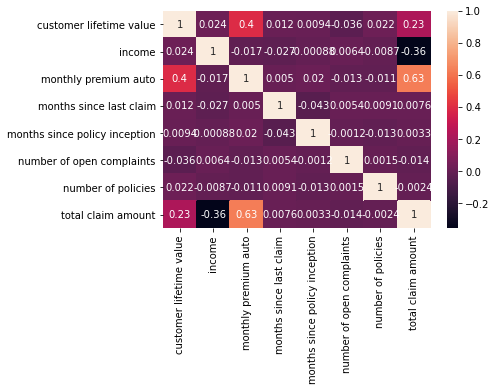

In [12]:
# Creating the heatmap
sns_plot = sns.heatmap(correlations_matrix, annot=True)
figure = sns_plot.get_figure()    
figure.savefig('svm_conf.png', dpi=400)
plt.show()

### 4. Processing Data

(_Further processing..._)

- X-y split.
- Normalize (numerical).

In [16]:
# considering 'total claim amount' as target and checking relevant stats
X = numerical.drop(['total claim amount'], axis=1)
y = numerical['total claim amount']

# with 'add_constant' we force the model to have an intercept
X = sm.add_constant(X)

model = sm.OLS(y,X).fit() # to train the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total claim amount   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     1405.
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:02:04   Log-Likelihood:                -61425.
No. Observations:                9134   AIC:                         1.229e+05
Df Residuals:                    9126   BIC:                         1.229e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Important variables: 'customer lifetime value', 'income', 'monthly premium auto'. When the target is 'total claim amount'.

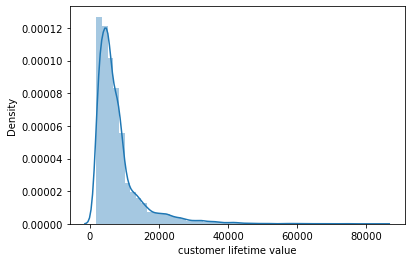

In [17]:
# Checking and correcting outliers for the important variables
sns.distplot(numerical['customer lifetime value'])
plt.show()

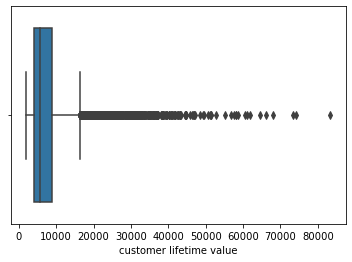

In [18]:
sns.boxplot(x=numerical['customer lifetime value'])
plt.show()

In [19]:
# removing outliers (defining interquartile range)

iqrCustomer = np.percentile(numerical['customer lifetime value'],75) - np.percentile(numerical['customer lifetime value'],25)
upper_limitCustomer = np.percentile(numerical['customer lifetime value'],75) + 1.5*iqrCustomer
lower_limitCustomer = np.percentile(numerical['customer lifetime value'],25) - 1.5*iqrCustomer
numerical = numerical[(numerical['customer lifetime value']>lower_limitCustomer) & (numerical['customer lifetime value']<upper_limitCustomer)]

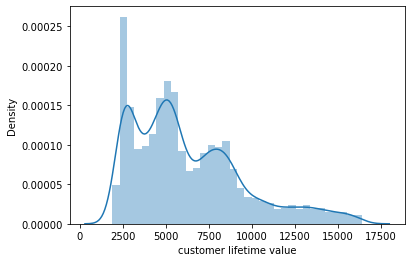

In [20]:
# check after changes
sns.distplot(numerical['customer lifetime value'])
plt.show()

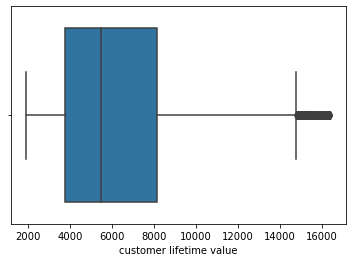

In [21]:
sns.boxplot(x=numerical['customer lifetime value'])
plt.show()

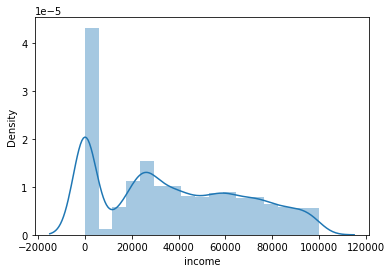

In [22]:
# Same for 'income'
sns.distplot(numerical['income'])
plt.show()

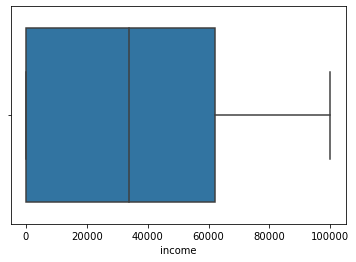

In [23]:
sns.boxplot(x=numerical['income'])
plt.show()

No outliers, no need to do any adjust

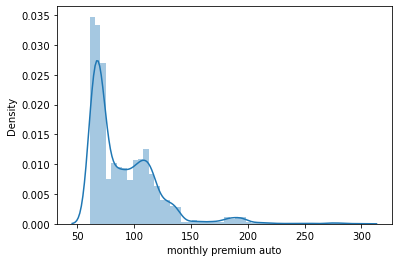

In [24]:
# Same for 'monthly premium auto'
sns.distplot(numerical['monthly premium auto'])
plt.show()

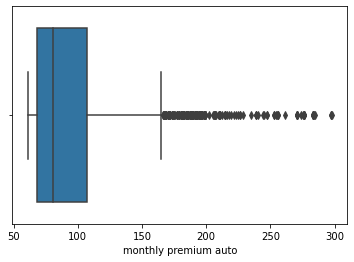

In [25]:
sns.boxplot(x=numerical['monthly premium auto'])
plt.show()

In [26]:
# removing outliers (defining interquartile range)

iqrPremium = np.percentile(numerical['monthly premium auto'],75) - np.percentile(numerical['monthly premium auto'],25)
upper_limitPremium = np.percentile(numerical['monthly premium auto'],75) + 1.5*iqrPremium
lower_limitPremium = np.percentile(numerical['monthly premium auto'],25) - 1.5*iqrPremium
numerical = numerical[(numerical['monthly premium auto']>lower_limitPremium) & (numerical['monthly premium auto']<upper_limitPremium)]

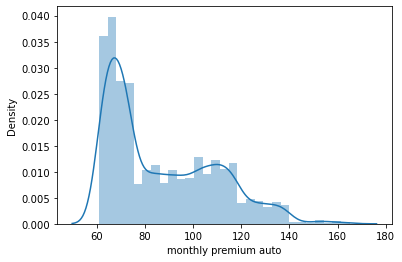

In [27]:
# check after changes
sns.distplot(numerical['monthly premium auto'])
plt.show()

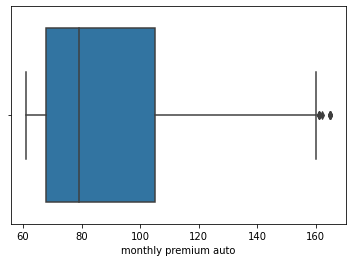

In [28]:
sns.boxplot(x=numerical['monthly premium auto'])
plt.show()

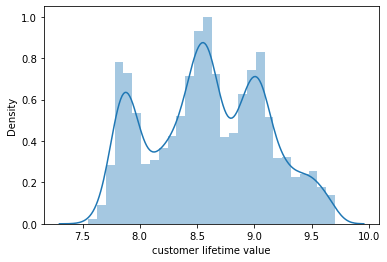

In [29]:
# "Normalise" your data 

data1 = numerical.copy()

# we are replacing the -inf values after we take logarithm of 0
# we'll test 2 options (replacing -inf by zero or by the mean of the column after the log transformation)

log_lmbda = lambda x: np.log(x) if np.isfinite(np.log(x)) else np.NAN

data1['customer lifetime value'] = data1['customer lifetime value'].apply(log_lmbda)

data1['customer lifetime value'] = data1['customer lifetime value'].fillna(np.mean(data1['customer lifetime value']))

sns.distplot(data1['customer lifetime value'])
plt.show()

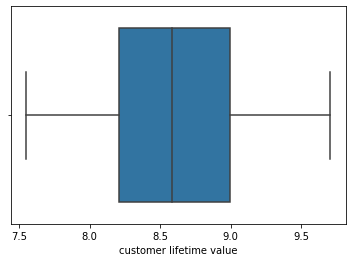

In [30]:
sns.boxplot(data1['customer lifetime value'])
plt.show()

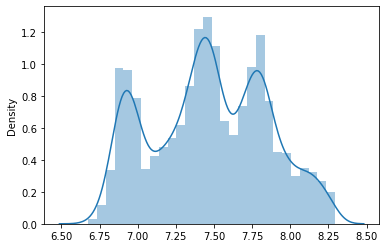

In [31]:
# BoxCox transformation

# Since this is median household income, we can filter out negative values:
# if you do not want to lose this data, replace it with the mean of the column

data1 = numerical.copy()

data1['customer lifetime value'] = np.where(numerical['customer lifetime value']<=0, np.NAN, numerical['customer lifetime value'])

data1['customer lifetime value'] = data1['customer lifetime value'].fillna(numerical['customer lifetime value'].mean())

transformed_data, _ci = stats.boxcox(data1['customer lifetime value'])

sns.distplot(transformed_data)
plt.show()

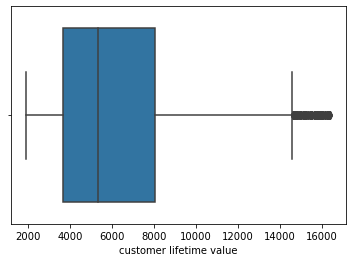

In [32]:
sns.boxplot(data1['customer lifetime value'])
plt.show()

Comparing the boxplots for 'customer lifetime value' after normalization:
It seems that the standard one worked better than the boxcox, because this last one gave a lot of outliers.

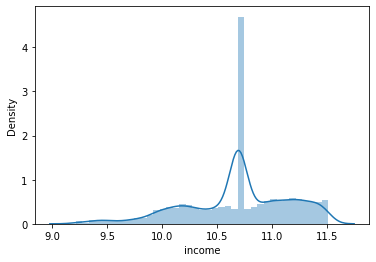

In [33]:
# The same for income

data1['income'] = data1['income'].apply(log_lmbda)

data1['income'] = data1['income'].fillna(np.mean(data1['income']))

sns.distplot(data1['income'])
plt.show()

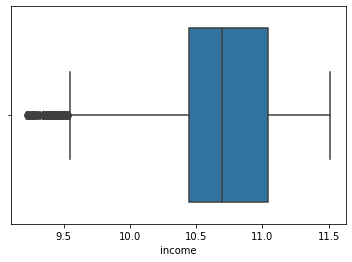

In [34]:
sns.boxplot(data1['income'])
plt.show()

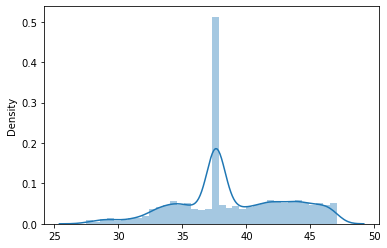

In [35]:
# BoxCox transformation

data1 = numerical.copy()

data1['income'] = np.where(numerical['income']<=0, np.NAN, numerical['income'])

data1['income'] = data1['income'].fillna(numerical['income'].mean())

transformed_data, _ci = stats.boxcox(data1['income'])

sns.distplot(transformed_data)
plt.show()

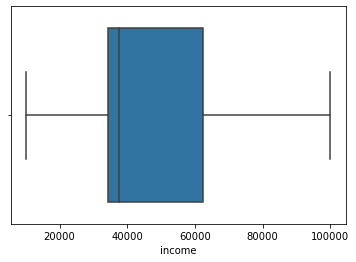

In [36]:
sns.boxplot(data1['income'])
plt.show()

For this variable instead, the boxcox transformation seems a better aproach when we compare both boxplots and its outliers.

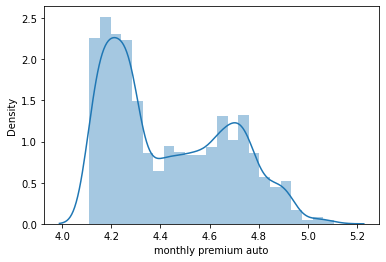

In [37]:
# The same for income

data1['monthly premium auto'] = data1['monthly premium auto'].apply(log_lmbda)

data1['monthly premium auto'] = data1['monthly premium auto'].fillna(np.mean(data1['monthly premium auto']))

sns.distplot(data1['monthly premium auto'])
plt.show()

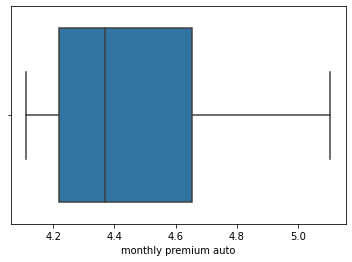

In [38]:
sns.boxplot(data1['monthly premium auto'])
plt.show()

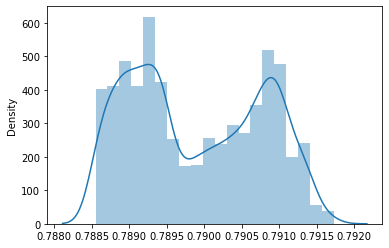

In [39]:
# BoxCox transformation

data1 = numerical.copy()

data1['monthly premium auto'] = np.where(numerical['monthly premium auto']<=0, np.NAN, numerical['monthly premium auto'])

data1['monthly premium auto'] = data1['monthly premium auto'].fillna(numerical['monthly premium auto'].mean())

transformed_data, _ci = stats.boxcox(data1['monthly premium auto'])

sns.distplot(transformed_data)
plt.show()

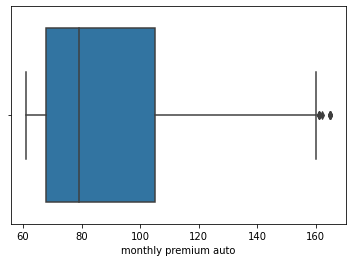

In [40]:
sns.boxplot(data1['monthly premium auto'])
plt.show()

A for the 'customer lifetime value' the standard normalization seems to have a better fit.